Successfully generated 93 valid sequences out of 100 requested samples.
Skipped 7 satellites due to incomplete or invalid sequences.
No saved GRU model found. Creating new one.
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1311 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0129 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0264 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 10/100
3/3 ━━━━━

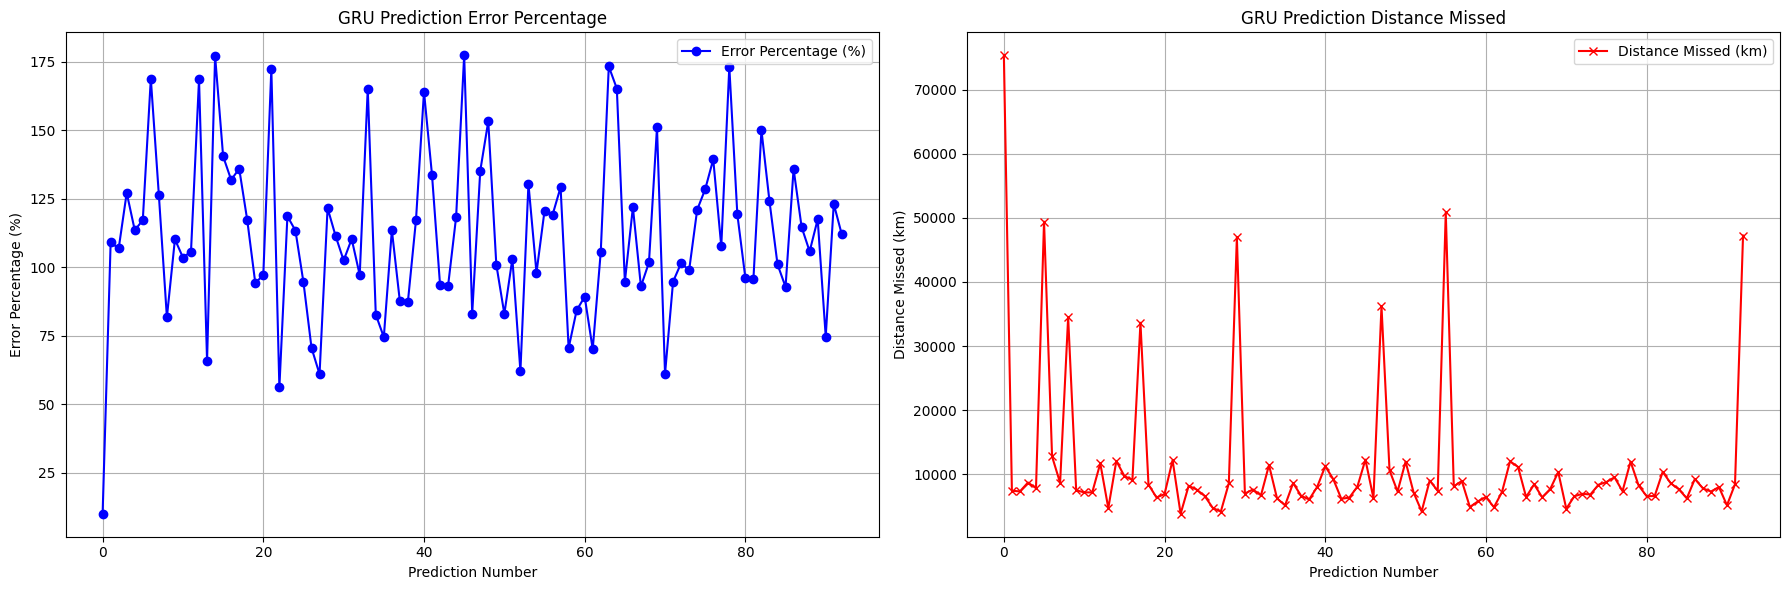

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sgp4.api import Satrec
from sgp4.conveniences import jday
from datetime import datetime, timezone, timedelta
import pandas as pd
import tkinter as tk
from tkinter import filedialog, messagebox, StringVar, OptionMenu 
import os
import random
import plotly.graph_objs as go
import plotly.io as pio
import json 
import joblib
import xgboost as xgb

# ================================
# Read TLE data from file
# ================================
def read_tle_from_txt(filename, num_samples):
    try:
        with open(filename, "r") as file:
            lines = file.readlines()
        
        tle_data = []
        for i in range(len(lines)):
            if "1 " in lines[i] and i + 1 < len(lines) and "2 " in lines[i + 1]:
                tle_data.append((lines[i - 1].strip(), lines[i].strip(), lines[i + 1].strip()))
        
        if len(tle_data) > num_samples:
            tle_data = random.sample(tle_data, num_samples)
        
        return tle_data
    
    except FileNotFoundError:
        print(f"Benchmark file {filename} not found.")
        return None

def read_simulated_orbit_file(filename, num_points=10):
    positions = []
    with open(filename, "r") as f:
        lines = f.readlines()[1:]
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 4:
                continue
            _, x, y, z = parts
            positions.append([float(x), float(y), float(z)])

    data = np.array(positions)
    sequences = []

    for i in range(len(data) - num_points):
        pos_seq = data[i:i + num_points]
        vel_seq = np.gradient(pos_seq, axis=0)  # Estimate velocity
        seq = np.concatenate([pos_seq, vel_seq], axis=1)  # shape (10, 6)
        sequences.append(seq)

    return np.array(sequences)  # shape: (N, 10, 6)

# ================================
# Build LSTM Model
# ================================
def build_lstm_model():
    model = keras.Sequential([
        Input(shape=(10, 3)),  
        layers.LSTM(128, return_sequences=True, stateful=False),  
        layers.Dropout(0.2),
        layers.LSTM(128, return_sequences=False, stateful=False),
        layers.Dropout(0.2),
        layers.Dense(3)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

# ================================
# Get satellite position and velocity
# ================================
def get_position_velocity(satellite, date_time):
    jd, fr = jday(date_time.year, date_time.month, date_time.day,
                  date_time.hour, date_time.minute, date_time.second + date_time.microsecond * 1e-6)
    e, r, v = satellite.sgp4(jd, fr)
    return np.array(r, dtype=np.float32) if e == 0 else None

# ================================
# Generate Benchmark Positions
# ================================
def generate_benchmark_positions(filename, num_samples, num_points=10):
    benchmark_tles = read_tle_from_txt(filename, num_samples)
    if not benchmark_tles:
        return np.array([]), np.array([])

    positions = []

    for name, tle1, tle2 in benchmark_tles:
        satellite = Satrec.twoline2rv(tle1, tle2)
        start_time = datetime.now(timezone.utc)
        sequence = []

        for i in range(num_points):
            date_time = start_time + timedelta(seconds=i * 10)
            position = get_position_velocity(satellite, date_time)
            if position is not None and np.all(np.isfinite(position)):
                sequence.append(position)

        # Only accept complete valid sequences
        if len(sequence) == num_points:
            positions.append(sequence)

    if not positions:
        print("No valid satellite sequences generated.")
        return np.array([]), np.array([])

    print(f"Successfully generated {len(positions)} valid sequences out of {len(benchmark_tles)} requested samples.")
    print(f"Skipped {len(benchmark_tles) - len(positions)} satellites due to incomplete or invalid sequences.")

    positions = np.array(positions)
    return np.array(positions)

def generate_advanced_mock_orbits(
    num_samples=10, num_points=10, 
    earth_radius_km=6371, 
    min_altitude_km=400, max_altitude_km=2000,
    eccentricity_range=(0.0, 0.2),
    perturb_std_km=10
):
    """
    Generate advanced mock satellite orbits (circular/elliptical, random orientation, with perturbations).
    Returns: np.ndarray of shape (num_samples, num_points, 3)
    """
    orbits = []
    for _ in range(num_samples):
        # Random orbital parameters
        a = earth_radius_km + np.random.uniform(min_altitude_km, max_altitude_km)  # semi-major axis
        e = np.random.uniform(*eccentricity_range)  # eccentricity
        inclination = np.deg2rad(np.random.uniform(0, 180))
        raan = np.deg2rad(np.random.uniform(0, 360))
        arg_perigee = np.deg2rad(np.random.uniform(0, 360))
        # True anomaly points
        points = []
        for f in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
            # Radius at true anomaly f
            r = a * (1 - e**2) / (1 + e * np.cos(f))
            # Position in orbital plane
            x_orb = r * np.cos(f)
            y_orb = r * np.sin(f)
            z_orb = 0
            # Rotation matrix for orientation
            # 1. Rotate by argument of perigee
            x1 = x_orb * np.cos(arg_perigee) - y_orb * np.sin(arg_perigee)
            y1 = x_orb * np.sin(arg_perigee) + y_orb * np.cos(arg_perigee)
            z1 = z_orb
            # 2. Rotate by inclination
            x2 = x1
            y2 = y1 * np.cos(inclination) - z1 * np.sin(inclination)
            z2 = y1 * np.sin(inclination) + z1 * np.cos(inclination)
            # 3. Rotate by RAAN
            x = x2 * np.cos(raan) - y2 * np.sin(raan)
            y = x2 * np.sin(raan) + y2 * np.cos(raan)
            z = z2
            # Add small random perturbation for realism
            x += np.random.normal(0, perturb_std_km)
            y += np.random.normal(0, perturb_std_km)
            z += np.random.normal(0, perturb_std_km)
            points.append([x, y, z])
        orbits.append(points)
    return np.array(orbits)  # shape: (num_samples, num_points, 3)

def get_future_positions(satellite, start_time, horizons_sec=[600, 1800, 3600]):
    """
    Returns a dict of {horizon_seconds: position (x, y, z)} for each horizon.
    """
    future_positions = {}
    for sec in horizons_sec:
        dt = start_time + timedelta(seconds=sec)
        pos = get_position_velocity(satellite, dt)
        if pos is not None and np.all(np.isfinite(pos)):
            future_positions[sec] = pos
        else:
            future_positions[sec] = None
    return future_positions

def generate_benchmark_positions_with_horizons(filename, num_samples, num_points=10, horizons_sec=[600,1800,3600]):
    benchmark_tles = read_tle_from_txt(filename, num_samples)
    if not benchmark_tles:
        return np.array([]), []

    positions = []
    future_truths = []

    for name, tle1, tle2 in benchmark_tles:
        satellite = Satrec.twoline2rv(tle1, tle2)
        start_time = datetime.now(timezone.utc)
        sequence = []

        for i in range(num_points):
            date_time = start_time + timedelta(seconds=i * 10)
            position = get_position_velocity(satellite, date_time)
            if position is not None and np.all(np.isfinite(position)):
                sequence.append(position)

        # Only accept complete valid sequences
        if len(sequence) == num_points:
            positions.append(sequence)
            # Get future positions for this satellite
            future_truths.append(get_future_positions(satellite, start_time, horizons_sec))

    if not positions:
        print("No valid satellite sequences generated.")
        return np.array([]), []

    print(f"Successfully generated {len(positions)} valid sequences out of {len(benchmark_tles)} requested samples.")
    return np.array(positions), future_truths

# ================================
# Train the LSTM Model
# ================================
def train_lstm_model(model, positions, epochs, batch_size):
    scaler = MinMaxScaler()
    num_sequences = positions.shape[0]

    positions_reshaped = positions.reshape(num_sequences * 10, 3)
    positions_scaled = scaler.fit_transform(positions_reshaped).reshape(num_sequences, 10, 3)
    ...
    X = positions_scaled[:, :-1, :]  # shape (N, 9, 3)
    y = positions_scaled[:, -1, :3]  # only predict x, y, z 


    if X.shape[0] == 0:
        print("Not enough data for LSTM training.")
        return None, scaler

    early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stop, lr_scheduler]
    )

    model.save("lstm_full_model.keras")
    print("Model weights saved.")

    joblib.dump(scaler, "lstm_scaler.pkl")

    return model, scaler

# ================================
# Train the GRU Model
# ================================
def train_gru_model(model, positions, epochs, batch_size):
    scaler = MinMaxScaler()
    num_sequences = positions.shape[0]
    X_raw = positions[:, :-1, :].reshape(-1, 3)
    scaler.fit(X_raw)

    positions_scaled = scaler.transform(positions.reshape(-1, 3)).reshape(positions.shape)

    # Adding Gaussian noise
    positions_scaled += np.random.normal(0, 0.001, positions_scaled.shape)

    # Prepare input/output pairs
    X, y = positions_scaled[:, :-1, :], positions_scaled[:, -1, :]

    if X.shape[0] == 0:
        print("Not enough data for GRU training.")
        return None, scaler

    # Define callbacks
    lr_scheduler = ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=5,
        verbose=1
    )
    early_stop = keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=30,
        restore_best_weights=True
    )

    # Fit model
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[lr_scheduler, early_stop]
    )

    model.save("gru_full_model.keras")
    print("GRU model weights saved.")

    joblib.dump(scaler, "gru_scaler.pkl")

    return model, scaler

# ================================
# Train XGBoost Model on Flattened Time-Series
# ================================
def train_xgboost_model(positions, epochs=None, batch_size=None, model_path="xgboost_model.json"):
    num_sequences = positions.shape[0]
    X = positions[:, :-1, :].reshape(num_sequences, 9 * 3)
    y = positions[:, -1, :]

    # If model exists, load and return it
    if os.path.exists(model_path):
        print(f"✅ Loaded existing XGBoost model from {model_path}")
        return joblib.load(model_path)

    # Else, train a new one
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        verbosity=1
    )
    model.fit(X, y)

    joblib.dump(model, model_path)
    print(f"✅ Trained and saved XGBoost model to {model_path}")
    return model

def evaluate_multi_horizon(model, scaler, input_sequence, horizons_sec=[600,1800,3600]):
    """
    input_sequence: shape (num_points, 3)
    Returns: dict {horizon_sec: predicted_position}
    """
    results = {}
    seq = np.copy(input_sequence)
    for horizon in horizons_sec:
        # Predict next position (roll forward)
        X = scaler.transform(seq[-9:]).reshape(1, 9, 3)
        pred = model.predict(X)
        pred = scaler.inverse_transform(pred).flatten()
        # For next step, append prediction to sequence
        seq = np.vstack([seq, pred])
        results[horizon] = pred
    return results

# ================================
# Load existing weights
# ================================
def load_existing_model(model_path):
    if os.path.exists(model_path):
        print(f"Loaded full model from {model_path}")
        return keras.models.load_model(model_path)
    else:
        print(f"No saved model found at {model_path}. Starting fresh.")
        return None

# Converting ECEF to lat/lon
def ecef_to_latlon(x, y, z):
    lon = np.arctan2(y, x) * (180 / np.pi)
    hyp = np.sqrt(x**2 + y**2)
    lat = np.arctan2(z, hyp) * (180 / np.pi)
    return lat, lon

# Function making 3d interactive plot of earth 
def plot_results(benchmark_positions, predictions, model_name="LSTM"):
    benchmark_latlon = np.array([ecef_to_latlon(x, y, z) for x, y, z in benchmark_positions[:, -1, :]])
    predicted_latlon = np.array([ecef_to_latlon(x, y, z) for x, y, z in predictions])

    fig = go.Figure()

    # Adding Earth's surface using a globe texture
    lats = np.linspace(-90, 90, 180)
    lons = np.linspace(-180, 180, 360)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    earth_radius = 6371  # Earth radius in km

    # Converting lat/lon to ECEF
    x = earth_radius * np.cos(np.radians(lat_grid)) * np.cos(np.radians(lon_grid))
    y = earth_radius * np.cos(np.radians(lat_grid)) * np.sin(np.radians(lon_grid))
    z = earth_radius * np.sin(np.radians(lat_grid))

    fig.add_trace(
        go.Surface(
            x=x,
            y=y,
            z=z,
            colorscale='earth',
            opacity=0.7 
        )
    )

    # Plotting benchmark positions
    fig.add_trace(
        go.Scatter3d(
            x=benchmark_positions[:, -1, 0],
            y=benchmark_positions[:, -1, 1],
            z=benchmark_positions[:, -1, 2],
            mode='markers',
            marker=dict(size=4, color='blue'),
            name='Benchmark'
        )
    )

    # Plotting predicted positions
    fig.add_trace(
        go.Scatter3d(
            x=predictions[:, 0],
            y=predictions[:, 1],
            z=predictions[:, 2],
            mode='markers',
            marker=dict(size=4, color='orange'),
            name='Prediction'
        )
    )

    # Layout adjustments
    fig.update_layout(
        title=f"{model_name} Satellite Tracking Prediction",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode='auto'
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )

    fig.show() # Displaying plot

# Function to save results of each real position (lat & lon) of a satellite, the LSTM's prediction 
# of the satellite's real position (lat & lon), and the error in that prediction measured by MSE
def save_predictions_for_cesium_with_actual(predictions, benchmark_positions, model_name="LSTM"):
    filename = f"predictions.json"
    output = []

    for idx in range(len(predictions)):
        orbit_sequence = [
            {"x": float(x)*1000, "y": float(y)*1000, "z": float(z)*1000}
            for x, y, z in benchmark_positions[idx]
        ]

        output.append({
            "id": f"Satellite {idx+1} - {model_name}",
            "orbit": orbit_sequence,
            "predicted": {
                "x": float(predictions[idx][0])*1000,
                "y": float(predictions[idx][1])*1000,
                "z": float(predictions[idx][2])*1000
            }
        })

    with open(filename, "w") as f:
        json.dump(output, f, indent=4)
    print(f"✅ Saved orbit + prediction data to {filename}")

def save_results_to_csv(benchmark_positions, predictions, model_name="LSTM"):
    filename = f"trackingresults_{model_name}.csv"
    data = []
    for i in range(len(predictions)):
        actual = benchmark_positions[i][-1]
        predicted = predictions[i]

        if isinstance(predicted, (list, np.ndarray)) and len(predicted) == 1 and hasattr(predicted[0], "__len__"):
            predicted = predicted[0]

        error = np.linalg.norm(np.array(actual) - np.array(predicted))

        data.append({
            "Satellite": f"Satellite {i+1}",
            "Benchmark Latitude": actual[0],
            "Benchmark Longitude": actual[1],
            "Benchmark Altitude": actual[2],
            "Predicted Latitude": predicted[0],
            "Predicted Longitude": predicted[1],
            "Predicted Altitude": predicted[2],
            "Error": error
        })

    pd.DataFrame(data).to_csv(filename, index=False)
    print(f"Results saved to {filename}")

def save_multi_horizon_results_to_csv(all_errors, model_name="LSTM"):
    """
    all_errors: list of dicts with keys: Satellite, Horizon_sec, Prediction, Truth, Error
    """
    filename = f"multi_horizon_results_{model_name}.csv"
    rows = []
    for entry in all_errors:
        pred = entry['Prediction']
        truth = entry['Truth']
        rows.append({
            "Satellite": entry['Satellite'],
            "Horizon_sec": entry['Horizon_sec'],
            "Prediction_X": pred[0],
            "Prediction_Y": pred[1],
            "Prediction_Z": pred[2],
            "Truth_X": truth[0],
            "Truth_Y": truth[1],
            "Truth_Z": truth[2],
            "Error": entry['Error']
        })
    pd.DataFrame(rows).to_csv(filename, index=False)
    print(f"Multi-horizon results saved to {filename}")

def save_multi_horizon_results_to_json(all_errors, model_name="LSTM"):
    filename = f"multi_horizon_results_{model_name}.json"
    with open(filename, "w") as f:
        json.dump(all_errors, f, indent=4)
    print(f"Multi-horizon results saved to {filename}")

def display_error_chart(model_name="LSTM"):
    filename = f"trackingresults_{model_name}.csv"
    try:
        df = pd.read_csv(filename)

        df['Error'] = np.sqrt(
            (df['Benchmark Latitude'] - df['Predicted Latitude'])**2 +
            (df['Benchmark Longitude'] - df['Predicted Longitude'])**2 +
            (df['Benchmark Altitude'] - df['Predicted Altitude'])**2
        )
        df['Distance Missed (km)'] = df['Error']

        df['Vector Magnitude'] = np.sqrt(
            df['Benchmark Latitude']**2 +
            df['Benchmark Longitude']**2 +
            df['Benchmark Altitude']**2
        )
        df = df[df['Vector Magnitude'] > 1000]

        df['Error Percentage'] = (df['Error'] / df['Vector Magnitude']) * 100

        # Create side-by-side subplots
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # Plot 1: Error Percentage
        axes[0].plot(df.index, df['Error Percentage'], label='Error Percentage (%)', color='blue', marker='o')
        axes[0].set_title(f'{model_name} Prediction Error Percentage')
        axes[0].set_xlabel('Prediction Number')
        axes[0].set_ylabel('Error Percentage (%)')
        axes[0].legend()
        axes[0].grid()

        # Plot 2: Distance Missed
        axes[1].plot(df.index, df['Distance Missed (km)'], label='Distance Missed (km)', color='red', marker='x')
        axes[1].set_title(f'{model_name} Prediction Distance Missed')
        axes[1].set_xlabel('Prediction Number')
        axes[1].set_ylabel('Distance Missed (km)')
        axes[1].legend()
        axes[1].grid()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating chart: {e}")

# ================================
# GUI Setup 
# ================================
def run_gui():
    def start_prediction(event=None):
        filename = filedialog.askopenfilename(title="Select TLE File")
        benchmark_positions = None

        if not filename:
            # Ask user if they want to use mock orbits
            use_mock = messagebox.askyesno("No file selected", "No TLE file selected. Use advanced mock orbits?")
            if use_mock:
                num_samples = int(sample_entry.get())
                benchmark_positions = generate_advanced_mock_orbits(num_samples=num_samples, num_points=10)
                print(f"Generated {num_samples} advanced mock orbits.")
            else:
                messagebox.showerror("Error", "No file selected")
                return
        else:
            try:
                num_samples = int(sample_entry.get())
                epochs = int(epoch_entry.get())
                batch_size = int(batch_entry.get())

                if "RK4" in filename.upper():
                    rk4_data = read_simulated_orbit_file(filename)
                    if rk4_data.shape[0] < 10:
                        messagebox.showerror("Error", "RK4 orbit data too short for prediction.")
                        return
                    benchmark_positions = rk4_data  # already shape: (N, 10, 3)
                    print(f"Loaded {benchmark_positions.shape[0]} simulated sequences.")
                else:
                    benchmark_positions = generate_benchmark_positions(filename, num_samples)

            except Exception as e:
                messagebox.showerror("Error", str(e))
                return

        try:
            epochs = int(epoch_entry.get())
            batch_size = int(batch_entry.get())
            selected_model = model_var.get()

            if selected_model == "LSTM":
                model_path = "lstm_full_model.keras"
                scaler_path = "lstm_scaler.pkl"

                if os.path.exists(model_path) and os.path.exists(scaler_path):
                    model = keras.models.load_model(model_path)
                    scaler = joblib.load(scaler_path)
                    print(f"Loaded LSTM model and scaler.")
                else:
                    model = build_lstm_model()
                    print("No saved LSTM model found. Creating new one.")
                    model, scaler = train_lstm_model(model, benchmark_positions, epochs, batch_size)

                X_raw = benchmark_positions[:, :-1, :].reshape(-1, 3)
                X_scaled = scaler.transform(X_raw).reshape(benchmark_positions.shape[0], 9, 3)
                predictions = model.predict(X_scaled)
                predictions = predictions.reshape(-1, 3)
                predictions = scaler.inverse_transform(predictions)

            elif selected_model == "GRU":
                model_path = "gru_full_model.keras"
                scaler_path = "gru_scaler.pkl"

                if os.path.exists(model_path) and os.path.exists(scaler_path):
                    model = keras.models.load_model(model_path)
                    scaler = joblib.load(scaler_path)
                    print(f"Loaded GRU model and scaler.")
                else:
                    model = keras.Sequential([
                        Input(shape=(10, 3)),
                        layers.GRU(128, return_sequences=True),
                        layers.Dropout(0.2),
                        layers.GRU(128),
                        layers.Dropout(0.2),
                        layers.Dense(3)
                    ])
                    model.compile(optimizer='adam', loss='mse')
                    print("No saved GRU model found. Creating new one.")
                    model, scaler = train_gru_model(model, benchmark_positions, epochs, batch_size)

                positions_scaled = scaler.transform(benchmark_positions.reshape(-1, 3)).reshape(benchmark_positions.shape)
                X = positions_scaled[:, :-1, :]
                predictions = model.predict(X)
                predictions = predictions.reshape(-1, 3)
                predictions = scaler.inverse_transform(predictions)

            elif selected_model == "XGBoost":
                model_path = "xgboost_model.json"
                model = train_xgboost_model(benchmark_positions, model_path=model_path)
                X_flattened = benchmark_positions[:, :-1, :].reshape(benchmark_positions.shape[0], 9 * 3)
                predictions = model.predict(X_flattened)

            print("Predictions complete.")

            save_predictions_for_cesium_with_actual(predictions, benchmark_positions, model_name=selected_model)
            save_results_to_csv(benchmark_positions, predictions, model_name=selected_model)
            plot_results(benchmark_positions, predictions, model_name=selected_model)
            display_error_chart(model_name=selected_model)

        except Exception as e:
            messagebox.showerror("Error", str(e))

    root = tk.Tk()
    root.title("Satellite Tracker")

    # Input for number of samples
    tk.Label(root, text="Number of Samples:").grid(row=0, column=0)
    sample_entry = tk.Entry(root)
    sample_entry.grid(row=0, column=1)

    # Input for epochs
    tk.Label(root, text="Epochs:").grid(row=1, column=0)
    epoch_entry = tk.Entry(root)
    epoch_entry.grid(row=1, column=1)

    # Input for batch size
    tk.Label(root, text="Batch Size:").grid(row=2, column=0)
    batch_entry = tk.Entry(root)
    batch_entry.grid(row=2, column=1)

    # Dropdown for selecting model
    tk.Label(root, text="Select Model:").grid(row=3, column=0)
    model_var = StringVar(root)
    model_var.set("LSTM")  # Default model
    model_dropdown = OptionMenu(root, model_var, "LSTM", "GRU", "XGBoost")
    model_dropdown.grid(row=3, column=1)

    # Start Prediction button
    tk.Button(root, text="Start Prediction", command=start_prediction).grid(row=4, column=0, columnspan=2)

    # Trigger start with "Enter" key
    root.bind('<Return>', start_prediction)

    root.mainloop()


# ================================
# Run the GUI
# ================================
if __name__ == "__main__":
    run_gui()
